In [1]:
!pip install -q scikit-image scipy

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset
import torch
import numpy as np, cv2, math, random, os, glob, csv
import matplotlib.pyplot as plt
from PIL import Image
from skimage.morphology import skeletonize
from scipy.optimize import curve_fit
from scipy.ndimage import median_filter
from skimage.morphology import skeletonize
from google.colab import files
from tqdm import tqdm
from sklearn.linear_model import RANSACRegressor
from sklearn.base import BaseEstimator, RegressorMixin

In [3]:
!unzip new_data.zip

Archive:  new_data.zip
replace new_data/image_0038.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: new_data/image_0038.bmp  


In [3]:
class CurveDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None, transform=None):
        self.imgs = sorted(glob.glob(os.path.join(img_dir, '*.bmp')))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)

        if self.transform:
            img = self.transform(image=img)['image']
        return img

In [4]:
ds = CurveDataset("/content/new_data")

100%|██████████| 159/159 [00:48<00:00,  3.28it/s]


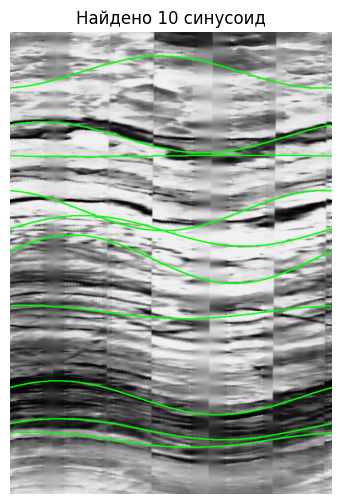

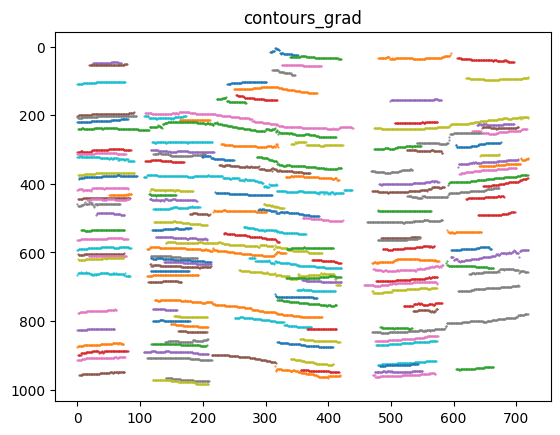

In [141]:
ω = None

def fit_sinusoid(points, ω, h, max_pts=2000):
    points = np.asarray(points)
    xs, ys = points[:, 0], points[:, 1]

    if len(xs) > max_pts:
        sel = np.random.choice(len(xs), max_pts, replace=False)
        xs, ys = xs[sel], ys[sel]

    order = np.argsort(xs)
    xs, ys = xs[order], ys[order]
    ys = median_filter(ys, size=5)

    class SineModel(BaseEstimator, RegressorMixin):
        def __init__(self, ω):
            self.ω = ω
            self.A = None
            self.θ = None
            self.y0 = None

        def fit(self, X, y):
            X = X.flatten()
            y = y.flatten()
            def sine_func(x, A, θ, y0):
                return A * np.sin(self.ω * x + θ) + y0

            p0 = (np.ptp(y)/2, 0, np.mean(y))
            try:
                params, _ = curve_fit(sine_func, X, y, p0=p0, maxfev=5000)
                self.A, self.θ, self.y0 = params
            except:
                self.A, self.θ, self.y0 = None, None, None
            return self

        def predict(self, X):
            if self.A is None:
                return np.zeros_like(X.flatten())
            return self.A * np.sin(self.ω * X.flatten() + self.θ) + self.y0

    model = SineModel(ω)
    ransac = RANSACRegressor(estimator=model, min_samples=0.4, residual_threshold=5.0, max_trials=10000)

    try:
        ransac.fit(xs.reshape(-1, 1), ys)
        A, θ, y0 = ransac.estimator_.A, ransac.estimator_.θ, ransac.estimator_.y0
        if A is None:
            return None
        if A < 0:
            A = -A
            θ = (θ + math.pi) % (2 * math.pi)
        return A, θ, y0
    except:
        return None

def inpaint_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = (gray == 0).astype(np.uint8) * 255
    inpainted = cv2.inpaint(gray, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return cv2.cvtColor(inpainted, cv2.COLOR_GRAY2RGB)

def gradient_edges(gray):
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    magnitude = cv2.magnitude(grad_x, grad_y)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, binary = cv2.threshold(magnitude, 40, 255, cv2.THRESH_BINARY)
    return binary

from skimage.morphology import skeletonize

def centerlines_from_grad(mask_bin, min_x_span=50, min_points=80):
    sk = skeletonize((mask_bin > 0)).astype(np.uint8) * 255

    num, labels = cv2.connectedComponents(sk)
    curves = []
    for lab in range(1, num):
        ys, xs = np.where(labels == lab)
        if xs.size < min_points:
            continue
        if np.ptp(xs) < min_x_span:
            continue

        by_x = {}
        for x, y in zip(xs, ys):
            by_x.setdefault(x, []).append(y)

        xs_sorted = sorted(by_x.keys())
        pts = np.array([[x, int(np.median(by_x[x]))] for x in xs_sorted], dtype=np.int32)
        curves.append(pts)

    return curves

def apply_clahe(img, input_limit = 15):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=input_limit, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    return img_clahe

def detect_and_draw(img_rgb,
                    background="rgb",
                    top_N=10,
                    min_len=40):

    h, w = img_rgb.shape[:2]
    ω = 2 * np.pi / w

    gray_crop = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    grad_mask = gradient_edges(gray_crop)
    contours_grad = centerlines_from_grad(grad_mask, min_x_span=30, min_points=60)

    scored = []

    from tqdm import tqdm

    for pts in tqdm(contours_grad):
            #if len(pts) < 30:
            #    continue

            fit = fit_sinusoid(pts, ω, h)
            if fit is None:
                continue
            A, θ, y0 = fit

            #if A < 2 or A > h / 1.5:
            #    continue

            xs, ys = pts[:, 0], pts[:, 1]
            rmse = np.sqrt(((ys - (A*np.sin(ω*xs + θ) + y0)) ** 2).mean())
            if rmse > 1:
                continue

            geom = len(pts) / rmse
            #if A > 200:
            #    continue
            scored.append((geom, rmse, A, θ, y0))

    scored.sort(key=lambda t: t[0], reverse=True)
    curves = [(A, θ, y0) for _, _, A, θ, y0 in scored[:top_N]]

    if background == "rgb":
        canvas = img_rgb.copy()
    else:
        canvas = cv2.cvtColor(grad_mask, cv2.COLOR_GRAY2BGR)

    xs_full = np.arange(w)
    for A, θ, y0 in curves:
        ys = (A * np.sin(ω * xs_full + θ) + y0).astype(int)
        good = (ys >= 0) & (ys < h)
        pts = np.column_stack([xs_full[good], ys[good]]).astype(np.int32)
        cv2.polylines(canvas, [pts], False, (0, 255, 0), 2)

    plt.figure(figsize=(8, 6))
    plt.imshow(canvas)
    plt.axis("off")
    plt.title(f"Найдено {len(curves)} синусоид")
    plt.show()

    for c in contours_grad:
        plt.plot(c[:, 0], c[:, 1], '.', markersize=1)
    plt.gca().invert_yaxis()
    plt.title("contours_grad")

sample_path = ds.imgs[0]
img = np.array(Image.open(sample_path).convert('RGB'))
img = inpaint_image(img)
#img = apply_clahe(img)

detect_and_draw(img_rgb=img)

In [20]:
img.shape

(1035, 720, 3)

In [14]:
def draw_sine(img, A, θ, y0, ω, color=(0, 255, 0), thickness=3):
    h, w = img.shape[:2]
    xs = np.arange(w)
    ys = (A * np.sin(ω * xs + θ) + y0).astype(int)
    mask = (ys >= 0) & (ys < h)
    pts = np.column_stack([xs[mask], ys[mask]]).astype(np.int32)
    if len(pts) > 1:
        cv2.polylines(img, [pts], isClosed=False, color=color, thickness=thickness)

In [15]:
model_csv = "/content/forest_model.pkl"

In [143]:
import joblib

saved = joblib.load(model_csv)
clf = saved['model']
scaler = saved['scaler']

In [144]:
IMG_PATH = "/content/5.bmp"
img = np.array(Image.open(IMG_PATH).convert("RGB"))
h, w = img.shape[:2]
ω = 2 * math.pi / w

up, down = 552, 555
PIX2MM = (down - up) / h * 1000

def process_image_by_tiles(img_rgb, up, down, step=256, stride=128, rmse_thr=1.0, top_N=10):
    h, w = img_rgb.shape[:2]
    ω = 2 * np.pi / w
    PIX2MM = (down - up) / h * 1000

    xs_full = np.arange(w)
    rows, rows_for_pred = [], []

    canvas = img_rgb.copy()
    from tqdm import tqdm

    for top in tqdm(range(0, h, stride)):
        bottom = min(h, top + step)
        crop = img_rgb[top:bottom]
        crop_h = crop.shape[0]

        gray_crop = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
        grad_mask = gradient_edges(gray_crop)
        curves = centerlines_from_grad(grad_mask, min_x_span=30, min_points=60)

        scored = []
        for pts in curves:
            fit = fit_sinusoid(pts, ω, crop_h)
            if fit is None:
                continue
            A_px, θ, y0 = fit
            xs, ys = pts[:, 0], pts[:, 1]
            rmse = np.sqrt(((ys - (A_px * np.sin(ω * xs + θ) + y0)) ** 2).mean())
            if rmse > rmse_thr:
                continue
            geom = len(pts) / rmse
            scored.append((geom, rmse, A_px, θ, y0))

        scored.sort(reverse=True, key=lambda t: t[0])
        selected = scored[:top_N]

        for _, rmse, A_px, θ, y0 in selected:
            y0_global = y0 + top
            A_mm = A_px * PIX2MM
            depth_m = up + (down - up) * (y0_global / h)

            rows.append([depth_m, A_mm, θ])
            rows_for_pred.append([depth_m, A_mm, θ, A_px, y0_global])

            ys_full = (A_px * np.sin(ω * xs_full + θ) + y0_global).astype(int)
            good = (ys_full >= 0) & (ys_full < h)
            pts_vis = np.column_stack([xs_full[good], ys_full[good]]).astype(np.int32)
            cv2.polylines(canvas, [pts_vis], False, (0, 255, 0), 2)

    return rows_for_pred

In [145]:
img = inpaint_image(img)
df_result = process_image_by_tiles(img, up, down, step=256, stride=128, top_N=10)

100%|██████████| 9/9 [02:24<00:00, 16.03s/it]


In [148]:
csv_path = "/content/result.csv"

df_result = pd.DataFrame(
    df_result,
    columns=["depth_m", "A_mm", "theta_rad", "A_px", "y0_global"]
)
X_pred_scaled = scaler.transform(df_result[["depth_m", "A_mm", "theta_rad"]])
y_pred = clf.predict(X_pred_scaled)

filtered = df_result[y_pred == 1][["depth_m", "A_mm", "theta_rad"]]

In [149]:
filtered["depth_rounded"] = filtered["depth_m"]
filtered_unique = (
    filtered.sort_values("A_mm", ascending=False)
    .drop_duplicates(subset="depth_rounded")
    .drop(columns="depth_rounded")
    .sort_values("depth_m")
)

rows_list = filtered_unique[["depth_m", "A_mm", "theta_rad"]].values.tolist()
rows_list.sort(key=lambda x: x[0])

THRESHOLD = 0.01
used = set()
averaged_rows = []

i = 0
while i < len(rows_list) - 1:
    d1 = rows_list[i][0]
    d2 = rows_list[i+1][0]

    if abs(d2 - d1) <= THRESHOLD:
        A_mm, theta = rows_list[i+1][1], rows_list[i+1][2]
        depth_avg = (d1 + d2) / 2

        averaged_rows.append([depth_avg, A_mm, theta])
        i += 2
    else:
        i += 1

df_avg = pd.DataFrame(averaged_rows, columns=["depth_m", "A_mm", "theta_rad"])
df_avg.to_csv(csv_path, index=False)

In [150]:
len(averaged_rows)

10

In [151]:
df = pd.read_csv("/content/result.csv")

In [152]:
df

,depth_m,A_mm,theta_rad
0,552.685113,102.316585,4.090605
1,553.150829,84.573535,4.060507
2,553.293759,95.030497,3.287522
3,553.675636,56.420827,4.111556
4,553.824024,43.095979,3.741348
5,553.868567,99.629284,-2.557390
6,553.929467,58.626259,-2.143678
7,554.459593,64.872283,-2.239798
8,554.585304,73.645391,-2.623370
9,554.698151,47.149591,3.946538


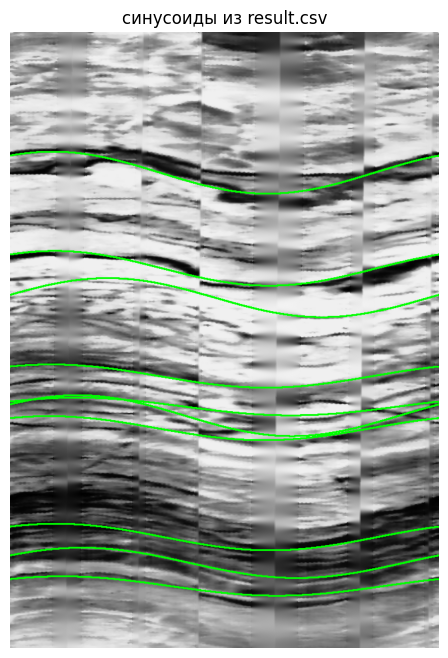

In [153]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

def draw_curves_from_csv(img_rgb, csv_path, up=552, down=555, color=(0, 255, 0), thickness=2):
    h, w = img_rgb.shape[:2]
    ω = 2 * math.pi / w
    PIX2MM = (down - up) / h * 1000

    df = pd.read_csv(csv_path)
    canvas = img_rgb.copy()
    xs_full = np.arange(w)

    for _, row in df.iterrows():
        depth_m, A_mm, theta = row["depth_m"], row["A_mm"], row["theta_rad"]

        y0 = h * (depth_m - up) / (down - up)
        A_px = A_mm / PIX2MM

        ys = (A_px * np.sin(ω * xs_full + theta) + y0).astype(int)
        valid = (ys >= 0) & (ys < h)
        pts = np.column_stack([xs_full[valid], ys[valid]]).astype(np.int32)

        if len(pts) > 1:
            cv2.polylines(canvas, [pts], False, color, thickness)

    plt.figure(figsize=(10, 8))
    plt.imshow(canvas)
    plt.axis("off")
    plt.title("синусоиды из result.csv")
    plt.show()

    return canvas


img = inpaint_image(img)

canvas = draw_curves_from_csv(img, csv_path="/content/result.csv")
